In [1]:
import os
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

from pprint import pprint
from torch.utils.data import DataLoader

In [2]:
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
import pandas as pd
import numpy as np
import copy

datasplit = pd.read_csv("../../baseline_images_stratified.csv",index_col=0)
datasplit.head()

,fl,bf,stencil,set,cell_line,index_in_dir,index_in_set
0,/gpfs/space/projects/PerkinElmer/seven_cell_li...,/gpfs/space/projects/PerkinElmer/seven_cell_li...,/gpfs/space/projects/PerkinElmer/seven_cell_li...,test,NIH3T3,0,0
1,/gpfs/space/projects/PerkinElmer/seven_cell_li...,/gpfs/space/projects/PerkinElmer/seven_cell_li...,/gpfs/space/projects/PerkinElmer/seven_cell_li...,val,NIH3T3,1,1
2,/gpfs/space/projects/PerkinElmer/seven_cell_li...,/gpfs/space/projects/PerkinElmer/seven_cell_li...,/gpfs/space/projects/PerkinElmer/seven_cell_li...,val,NIH3T3,2,2
3,/gpfs/space/projects/PerkinElmer/seven_cell_li...,/gpfs/space/projects/PerkinElmer/seven_cell_li...,/gpfs/space/projects/PerkinElmer/seven_cell_li...,train,NIH3T3,3,3
4,/gpfs/space/projects/PerkinElmer/seven_cell_li...,/gpfs/space/projects/PerkinElmer/seven_cell_li...,/gpfs/space/projects/PerkinElmer/seven_cell_li...,train,NIH3T3,4,4


In [20]:
filenames = list(zip(datasplit[datasplit.set=="val"].bf.values, datasplit[datasplit.set=="val"].stencil.values))
filenames[:10]

[('/gpfs/space/projects/PerkinElmer/seven_cell_lines/images/0102K1F2P1R2.png',
  '/gpfs/space/projects/PerkinElmer/seven_cell_lines/complete_stencils/0102K1F2P1R1.png'),
 ('/gpfs/space/projects/PerkinElmer/seven_cell_lines/images/0102K1F3P1R2.png',
  '/gpfs/space/projects/PerkinElmer/seven_cell_lines/complete_stencils/0102K1F3P1R1.png'),
 ('/gpfs/space/projects/PerkinElmer/seven_cell_lines/images/0103K1F7P1R2.png',
  '/gpfs/space/projects/PerkinElmer/seven_cell_lines/complete_stencils/0103K1F7P1R1.png'),
 ('/gpfs/space/projects/PerkinElmer/seven_cell_lines/images/0103K1F8P1R2.png',
  '/gpfs/space/projects/PerkinElmer/seven_cell_lines/complete_stencils/0103K1F8P1R1.png'),
 ('/gpfs/space/projects/PerkinElmer/seven_cell_lines/images/0104K1F7P1R2.png',
  '/gpfs/space/projects/PerkinElmer/seven_cell_lines/complete_stencils/0104K1F7P1R1.png'),
 ('/gpfs/space/projects/PerkinElmer/seven_cell_lines/images/0105K1F3P1R2.png',
  '/gpfs/space/projects/PerkinElmer/seven_cell_lines/complete_stencils/

In [21]:
local_image_folder = "../../data/images/"
fl_sample = datasplit.fl.values[0]
fl_sample = fl_sample[fl_sample.rfind("/")+1:]
fl_sample = os.path.join(local_image_folder, fl_sample)
fl_sample

'../../data/images/0102K1F1P1R1.png'

In [22]:
fl = np.array(Image.open(fl_sample))
fl.shape

(1080, 1080)

In [23]:
np.min(fl),np.max(fl)

(34, 35876)

In [24]:
bf_sample = datasplit.bf.values[0]
bf_sample = bf_sample[bf_sample.rfind("/")+1:]
bf_sample = os.path.join(local_image_folder, bf_sample)
bf_sample

'../../data/images/0102K1F1P1R2.png'

In [25]:
bf = np.array(Image.open(bf_sample))
bf.shape

(1080, 1080)

In [26]:
np.max(bf)

12508

In [27]:
np.min(bf)

2381

In [28]:
st_sample = datasplit.stencil.values[0]
st_sample = st_sample[st_sample.rfind("/")+1:]
st_sample = os.path.join(local_image_folder, st_sample)
st_sample

'../../data/images/0102K1F1P1R1.png'

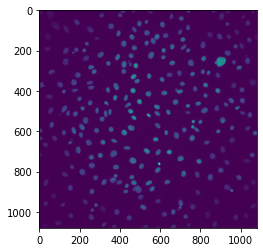

In [29]:
stencil = np.array(Image.open(st_sample))
plt.imshow(stencil)

In [30]:
stencil.shape

(1080, 1080)

In [31]:
stencil[:30,:10]

array([[ 259,  457,  773, 1083, 1260, 1322, 1364, 1395, 1375, 1367],
       [ 364,  695, 1067, 1350, 1522, 1691, 1697, 1557, 1517, 1484],
       [ 562, 1021, 1397, 1649, 1878, 2028, 1953, 1778, 1694, 1597],
       [ 852, 1418, 1703, 1857, 2045, 2163, 2044, 1871, 1759, 1694],
       [1088, 1653, 1872, 1934, 2006, 2044, 1912, 1782, 1721, 1759],
       [1228, 1772, 1993, 1989, 2002, 1954, 1801, 1740, 1792, 1920],
       [1276, 1811, 2053, 2094, 2127, 2047, 1866, 1819, 1953, 2077],
       [1269, 1769, 2043, 2178, 2213, 2151, 2051, 2007, 2043, 2016],
       [1253, 1688, 2008, 2183, 2154, 2109, 2137, 2099, 1998, 1853],
       [1196, 1605, 1894, 2085, 2067, 1987, 2009, 2000, 1925, 1783],
       [1082, 1523, 1780, 1943, 1937, 1865, 1886, 1942, 1981, 1833],
       [ 952, 1370, 1653, 1801, 1774, 1681, 1737, 1890, 1994, 1892],
       [ 813, 1145, 1396, 1593, 1704, 1754, 1753, 1820, 1948, 1929],
       [ 639,  946, 1190, 1456, 1679, 1816, 1829, 1835, 1872, 1812],
       [ 477,  807, 1082, 1365, 15

In [32]:
np.min(stencil),np.max(stencil)

(34, 35876)

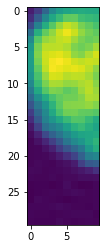

In [33]:
plt.imshow(stencil[:30,:10])

$\frac{value - min}{max - min}$

In [85]:
## Apply threshold

th_stencil = copy.deepcopy(stencil)
th_stencil = th_stencil - np.min(stencil)
th_stencil = th_stencil / (np.max(stencil) - np.min(stencil))
threshold = 0.01

th_stencil[th_stencil<=threshold] = 0.0
th_stencil[th_stencil>threshold] = 1.0
print(np.min(th_stencil), np.max(th_stencil))


1.0 1.0


In [82]:
cut = th_stencil[:30,:10]
cut

array([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 

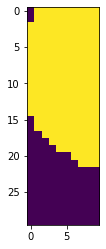

In [83]:
plt.imshow(th_stencil[:30,:10])

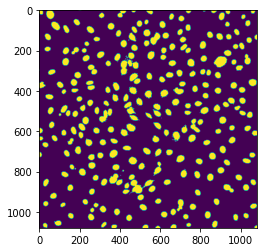

In [84]:
plt.imshow(th_stencil)

In [56]:
from tqdm import tqdm
## Apply thershold to all stencils
threshold = 1000
th_dir = f"../../data/th{threshold}_stencils"
os.makedirs(th_dir, exist_ok=True)

for stencil in tqdm(datasplit.stencil.values):
    st_file = stencil[stencil.rfind("/")+1:]
    st_path = os.path.join(local_image_folder, st_file)
    st_array = np.array(Image.open(st_path))
    st_array[st_array<1000] = 0
    st_array[st_array>=1000] = 1
    Image.fromarray(st_array).save(os.path.join(th_dir,st_file), format='png')

100%|███████████████████████████████████████████████████████████████████████████████| 3024/3024 [03:53<00:00, 12.93it/s]


In [4]:
from brightfield import BrightfieldDataset
import torchvision.transforms as transforms

In [5]:
root = "../../data/"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose(
    [transforms.Resize((256,256)),     
     transforms.ToTensor(),
     transforms.ConvertImageDtype(torch.float32)])

In [6]:
# data = {"image": fl, "mask": stencil}
        
# augmented = transform(**data)
# image, mask = augmented["image"], augmented["mask"]

In [7]:
train_dataset = BrightfieldDataset(root, "train", split_file="../../baseline_images_stratified.csv", transform=transform)
# valid_dataset = SimpleOxfordPetDataset(root, "valid")
# test_dataset = SimpleOxfordPetDataset(root, "test")

In [8]:
print(f"Train size: {len(train_dataset)}")
# print(f"Valid size: {len(valid_dataset)}")
# print(f"Test size: {len(test_dataset)}")

n_cpu = os.cpu_count()
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=n_cpu)

Train size: 2016


../../data/complete_stencils/0102K1F4P1R1.png


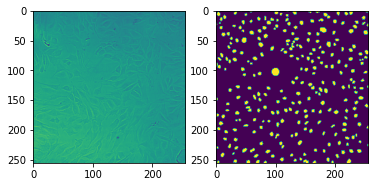

In [9]:
sample = train_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].numpy().transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].numpy().transpose(1, 2, 0).squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

In [33]:
sample["image"].numpy().transpose(1, 2, 0).shape

(256, 256, 1)

In [36]:
sample["mask"].numpy().transpose(1, 2, 0).shape

(256, 256, 1)

In [38]:
np.max(sample["mask"].numpy()[0:100, 0:100])

0.0

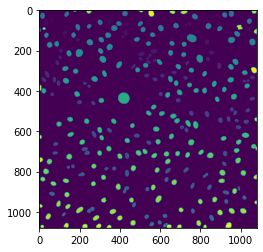

In [14]:
mask = Image.open("../../data/complete_stencils/0102K1F4P1R1.png")
mask = np.array(mask)
plt.imshow(mask)

(array([[1080.,    0.,    0., ...,    0.,    0.,    0.],
        [ 965.,    0.,    0., ...,    0.,    0.,  115.],
        [ 965.,    0.,    0., ...,    0.,    0.,  115.],
        ...,
        [ 954.,    0.,    0., ...,    0.,    0.,  126.],
        [ 962.,    0.,    0., ...,    0.,    0.,  118.],
        [1080.,    0.,    0., ...,    0.,    0.,    0.]]),
 array([  0. ,  28.6,  57.2,  85.8, 114.4, 143. , 171.6, 200.2, 228.8,
        257.4, 286. ]),
 <a list of 1080 BarContainer objects>)

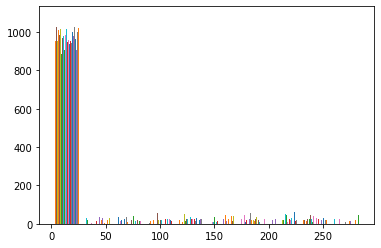

In [18]:
plt.hist(mask)

In [ ]:
mask = self._preprocess_mask(mask, self.mask_threshold)

if self.transform is not None:
    image = self.transform(image)
    mask  = self.transform(mask)

sample = dict(image=image, mask=mask)    